In [3]:
# Import the necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## utils
import time
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


### Outline:

- prepare train loader + data augmentation
- definitions and configuaryion of NN
- adding layers
- apply robust techniques (early stopping, regualarization, dropout)

In [18]:
transformTrainAug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainData = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transformTest)
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=64,shuffle=True, num_workers=2)

trainDataAug =  torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transformTrainAug)
trainLoaderAug = torch.utils.data.DataLoader(trainDataAug, batch_size=64,shuffle=True, num_workers=2)

testData = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transformTest)
testLoader = torch.utils.data.DataLoader(testData, batch_size=64, shuffle=False, num_workers=2)

Defnition of 2-3 layered CNNs

In [21]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x



class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

Defining training end evaluation function

In [22]:
def trainModel(nnModel, trainLoader, optimizerMethod=optim.SGD, lossFunction=nn.CrossEntropyLoss(), lRate = 0.005, n_epochs = 10):
    optimizer = optimizerMethod(nnModel.parameters(), lRate, momentum=0.5)

    start = time.time()
    for epch in range(n_epochs): 
        # before each epoch DataLoader reshuffles 
        for idx,dataBatch in enumerate(trainLoader):
            input, labels = dataBatch
            
            # zeroing out the gradient
            optimizer.zero_grad()

            # forward + backward + optimize
            output = nnModel(input)
            loss = lossFunction(output, labels)
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                print(f"Loss: {loss.item():.3f}  Epoch:{epch} Iteration:{idx}")
    
    end = time.time()
    return nnModel, end - start

def evalNN(nnModel, testLoader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            outputs = nnModel(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true += labels.cpu().numpy().tolist()
            y_pred += predicted.cpu().numpy().tolist()

        return y_true, y_pred

### Training and evaluating the NN with 3 layers

In [23]:
trainedNet, meausured_time  = trainModel(Net3(), trainLoader)

Loss: 2.332  Epoch:0 Iteration:0
Loss: 0.708  Epoch:0 Iteration:100
Loss: 0.598  Epoch:0 Iteration:200
Loss: 0.408  Epoch:0 Iteration:300
Loss: 0.334  Epoch:0 Iteration:400
Loss: 0.479  Epoch:0 Iteration:500
Loss: 0.477  Epoch:0 Iteration:600
Loss: 0.584  Epoch:0 Iteration:700
Loss: 0.329  Epoch:0 Iteration:800
Loss: 0.311  Epoch:0 Iteration:900
Loss: 0.295  Epoch:1 Iteration:0
Loss: 0.226  Epoch:1 Iteration:100
Loss: 0.643  Epoch:1 Iteration:200
Loss: 0.278  Epoch:1 Iteration:300
Loss: 0.343  Epoch:1 Iteration:400
Loss: 0.219  Epoch:1 Iteration:500
Loss: 0.250  Epoch:1 Iteration:600
Loss: 0.172  Epoch:1 Iteration:700
Loss: 0.355  Epoch:1 Iteration:800
Loss: 0.250  Epoch:1 Iteration:900
Loss: 0.216  Epoch:2 Iteration:0
Loss: 0.279  Epoch:2 Iteration:100
Loss: 0.420  Epoch:2 Iteration:200
Loss: 0.177  Epoch:2 Iteration:300
Loss: 0.296  Epoch:2 Iteration:400
Loss: 0.284  Epoch:2 Iteration:500
Loss: 0.337  Epoch:2 Iteration:600
Loss: 0.137  Epoch:2 Iteration:700
Loss: 0.212  Epoch:2 Itera

In [24]:
label_true, label_pred = evalNN(trainedNet, testLoader)

Metrics:

In [25]:
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":meausured_time}])

,Accuracy,Precision,Trainig time
0,0.911,0.913104,540.210593


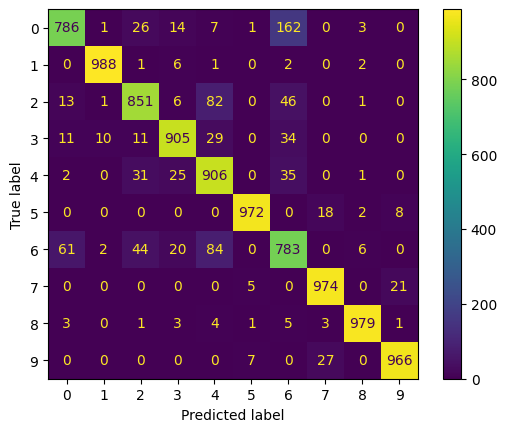

In [26]:
ConfusionMatrixDisplay.from_predictions(label_true, label_pred)
plt.show()

### Training 2-layered CNN

In [27]:
trainedNet2, timeNet2 = trainModel(Net2(), trainLoader)

Loss: 2.299  Epoch:0 Iteration:0
Loss: 0.532  Epoch:0 Iteration:100
Loss: 0.588  Epoch:0 Iteration:200
Loss: 0.674  Epoch:0 Iteration:300
Loss: 0.444  Epoch:0 Iteration:400
Loss: 0.276  Epoch:0 Iteration:500
Loss: 0.609  Epoch:0 Iteration:600
Loss: 0.348  Epoch:0 Iteration:700
Loss: 0.440  Epoch:0 Iteration:800
Loss: 0.364  Epoch:0 Iteration:900
Loss: 0.340  Epoch:1 Iteration:0
Loss: 0.406  Epoch:1 Iteration:100
Loss: 0.510  Epoch:1 Iteration:200
Loss: 0.383  Epoch:1 Iteration:300
Loss: 0.274  Epoch:1 Iteration:400
Loss: 0.346  Epoch:1 Iteration:500
Loss: 0.288  Epoch:1 Iteration:600
Loss: 0.429  Epoch:1 Iteration:700
Loss: 0.174  Epoch:1 Iteration:800
Loss: 0.275  Epoch:1 Iteration:900
Loss: 0.232  Epoch:2 Iteration:0
Loss: 0.312  Epoch:2 Iteration:100
Loss: 0.227  Epoch:2 Iteration:200
Loss: 0.146  Epoch:2 Iteration:300
Loss: 0.243  Epoch:2 Iteration:400
Loss: 0.340  Epoch:2 Iteration:500
Loss: 0.270  Epoch:2 Iteration:600
Loss: 0.335  Epoch:2 Iteration:700
Loss: 0.217  Epoch:2 Itera

In [28]:
label_true, label_pred = evalNN(trainedNet2, testLoader)
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":timeNet2}])

,Accuracy,Precision,Trainig time
0,0.9132,0.913982,373.788821


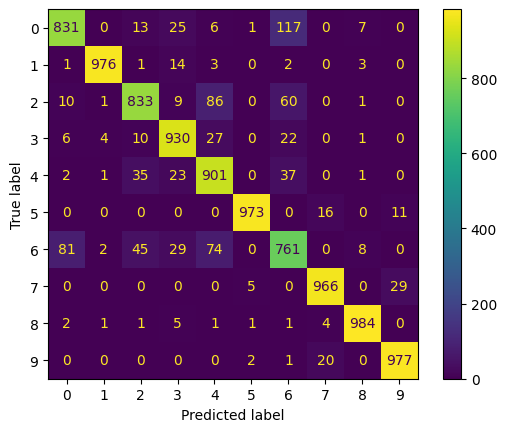

In [29]:
ConfusionMatrixDisplay.from_predictions(label_true, label_pred)
plt.show()

### Applying Data Augmentation

data was augmented with Random horizontal flipped images and random cropped images

In [30]:
# 2-layered augmented neural network
trainedNetAug2, meausured_timeAug2  = trainModel(Net2(), trainLoaderAug)
label_true, label_pred = evalNN(trainedNetAug2, testLoader)
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":meausured_timeAug2}])

Loss: 2.344  Epoch:0 Iteration:0
Loss: 1.056  Epoch:0 Iteration:100
Loss: 0.846  Epoch:0 Iteration:200
Loss: 0.902  Epoch:0 Iteration:300
Loss: 0.768  Epoch:0 Iteration:400
Loss: 0.818  Epoch:0 Iteration:500
Loss: 0.590  Epoch:0 Iteration:600
Loss: 0.923  Epoch:0 Iteration:700
Loss: 0.630  Epoch:0 Iteration:800
Loss: 0.597  Epoch:0 Iteration:900
Loss: 0.421  Epoch:1 Iteration:0
Loss: 0.430  Epoch:1 Iteration:100
Loss: 0.526  Epoch:1 Iteration:200
Loss: 0.595  Epoch:1 Iteration:300
Loss: 0.633  Epoch:1 Iteration:400
Loss: 0.718  Epoch:1 Iteration:500
Loss: 0.618  Epoch:1 Iteration:600
Loss: 0.496  Epoch:1 Iteration:700
Loss: 0.650  Epoch:1 Iteration:800
Loss: 0.565  Epoch:1 Iteration:900
Loss: 0.357  Epoch:2 Iteration:0
Loss: 0.428  Epoch:2 Iteration:100
Loss: 0.534  Epoch:2 Iteration:200
Loss: 0.301  Epoch:2 Iteration:300
Loss: 0.321  Epoch:2 Iteration:400
Loss: 0.536  Epoch:2 Iteration:500
Loss: 0.422  Epoch:2 Iteration:600
Loss: 0.334  Epoch:2 Iteration:700
Loss: 0.334  Epoch:2 Itera

,Accuracy,Precision,Trainig time
0,0.8859,0.885767,380.847688


In [31]:
# 3-layered augmented neural network
trainedNetAug3, meausured_timeAug3  = trainModel(Net3(), trainLoaderAug)
label_true, label_pred = evalNN(trainedNetAug3, testLoader)
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":meausured_timeAug3}])

Loss: 2.314  Epoch:0 Iteration:0
Loss: 0.969  Epoch:0 Iteration:100
Loss: 0.770  Epoch:0 Iteration:200
Loss: 0.901  Epoch:0 Iteration:300
Loss: 0.503  Epoch:0 Iteration:400
Loss: 0.629  Epoch:0 Iteration:500
Loss: 0.575  Epoch:0 Iteration:600
Loss: 0.664  Epoch:0 Iteration:700
Loss: 0.648  Epoch:0 Iteration:800
Loss: 0.475  Epoch:0 Iteration:900
Loss: 0.575  Epoch:1 Iteration:0
Loss: 0.580  Epoch:1 Iteration:100
Loss: 0.412  Epoch:1 Iteration:200
Loss: 0.340  Epoch:1 Iteration:300
Loss: 0.569  Epoch:1 Iteration:400
Loss: 0.576  Epoch:1 Iteration:500
Loss: 0.369  Epoch:1 Iteration:600
Loss: 0.481  Epoch:1 Iteration:700
Loss: 0.380  Epoch:1 Iteration:800
Loss: 0.503  Epoch:1 Iteration:900
Loss: 0.664  Epoch:2 Iteration:0
Loss: 0.535  Epoch:2 Iteration:100
Loss: 0.347  Epoch:2 Iteration:200
Loss: 0.454  Epoch:2 Iteration:300
Loss: 0.552  Epoch:2 Iteration:400
Loss: 0.404  Epoch:2 Iteration:500
Loss: 0.541  Epoch:2 Iteration:600
Loss: 0.399  Epoch:2 Iteration:700
Loss: 0.303  Epoch:2 Itera

,Accuracy,Precision,Trainig time
0,0.8882,0.891695,526.396462
